# The Chi Squared  test

Evgeny Kolonsky 2025

v.0.1.2

Reference:

John R. Taylor. *An Introduction to Error Analysis: The Study of Uncertainties in Physical Measurements.* University Science Books, 1996. ISBN 093570275X.

See **Chapter 12 "The Chi-squared test for distribution"**

In [1]:
import numpy as np
from scipy.stats import chi2, poisson, norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io

# Intro. General form

(cited from [Taylor])

$$
\chi^2 = \sum_{\text{bins}}^n
\left(
    \frac{\text{observed value} - \text{expected value}}{\text{standard deviation}}
\right)^2    
$$
$\chi^2$ is an indicator of the agreement between the observed and expected valued of some variable. If agreement is good, $\chi^2$ will be in order of $n$; if it is poor, $\chi^2$ will be much greater that $n$. Here $n$ - number of bins.

# Discrete case

Random value $x_i$ is discrete, e.g. events counter.



$$
\chi^2 = \sum_{k=1}^n
    \frac{(O_k - E_k)^2}{E_k}
$$
where $O_k$ is observed number of events falling to bin $k$, $E_k$  is expected number of events belonging to bin $k$, and $n$ - number of bins.

## Example. Poisson distribution test

See Table 12.9 in [Taylor].


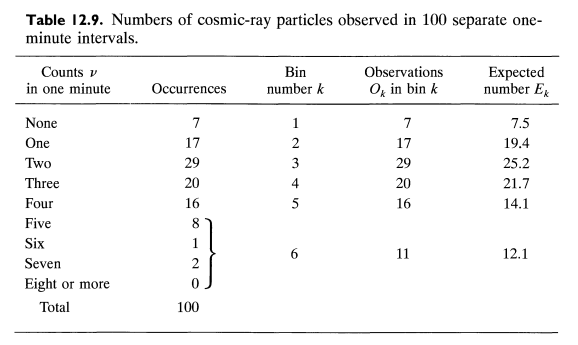

In [6]:
measurements = '''
# counts occurences
0 7
1 17
2 29
3 20
4 16
5 8
6 1
7 2
# Eight and more
8 0
'''
counts, occurences = np.genfromtxt(measurements.splitlines(), skip_header=1, dtype=int).T

# number of bins
n = 6
bins = range(n)
N = occurences.sum()
print(f'Total number of observations N = {N:.0f}')
mu = np.sum(counts * occurences) / N
print(f'Average counts value {mu = :.2f}')

# pack  occurences to bins and calculate Ok
observed = [occurences[i] for i in range(n-1)] + [occurences[n-1:].sum()]
observed = np.array(observed)

# calculate expected number Ek
p = poisson(mu)
expected = p.pmf(bins) * N
# last bin for all other probabilities
expected[-1] =  N - expected[:-1].sum()
for k in range(n):
  print(f'Bin {k}     observed {observed[k]:>5.0f}    expected {expected[k]:>5.1f}')

# calculate chi sqared test
chi2_observed = np.sum((observed - expected)**2 / expected)
print(f'Chi-squared {chi2_observed:.2f}')



Total number of observations N = 100
Average counts value mu = 2.59
Bin 0     observed     7    expected   7.5
Bin 1     observed    17    expected  19.4
Bin 2     observed    29    expected  25.2
Bin 3     observed    20    expected  21.7
Bin 4     observed    16    expected  14.1
Bin 5     observed    11    expected  12.1
Chi-squared 1.43


Conclusion: chi squared observed $\chi^2=1.43$ is less than number of bins $n=6$. Therefore, the measurements are likely taken from Poisson distribution.

# Degrees of Freedom and Reduced Chi Squared

Number of degrees of freedom
$$d = n-c$$ is always less than the number of bins $n$ by the number of constraints $c$. When $n$ is big enough, $d \approx n$.

Reduced chi squared (or *chi squared per degree of freedom*) is
$$
\tilde \chi^2 = \chi^2 / d.
$$
Since the expected value of $\chi^2$ is $d$, we see that
$$
\text{(expected average value of $\tilde \chi^2$ )} \approx 1.
$$

Oure test can be stated as follows:
if we obtaing a value of $\tilde \chi^2$ of order one or less, then we have no reason to doubt our expected distribution; if we obtain value of $\tilde \chi^2$ much larger that one, our expected distribution is unlikely to be correct.

# Confidence

After completing any series of measuremens, we calculate reduced chi sqaured, which we denote $\tilde \chi^2_o$ (where subscript $o$ stands for *observed*, because the value $\tilde \chi^2_o$ is actally observed). Next, assuming our measurements do follow the expected distribution, we compute the probability
$$
Prob(\tilde \chi^2 > \tilde \chi^2_o)
$$
of finding a value $\tilde \chi^2$ greater than or equal to the observed value $\tilde \chi^2_o$.  If this probability is high, our value is perfectly acceptable, and we have no reason to reject our expected distribution. If this probability is unreasonably low, a value of $\tilde \chi^2$ as large as our observed $\tilde \chi^2_o$ is very unlikely (if our measurements were distributed as expected), and our expected distribution is correspondingly unlikely to be correct.

With the boundary at 5%, we would say that our observed value $\tilde \chi^2_o$ indicates *significant disagreement* if
$$
Prob(\tilde \chi^2 > \tilde \chi^2_o) < 5\%.
$$


# Continuous case



Two variables are measured, $x$ and $y$, where $y$ is expected to be some definite function of $x$:
$$
y = f(x)
$$
(such as $y = a x^2$).

Suppose we have $N$ measured pairs $(x_i, y_i)$, where $x_i$ have negligible uncertainty and the $y_i$ have known uncertainties $\sigma_i$. Here, the expected value of $y_i$ is $f(x_i)$, and we could test how well $y$ fits the function $f(x)$ by calculating
$$
\chi^2 = \sum_1^N
\left(
  \frac{y_i - f(x_i)}{\sigma_i}
\right)^2  
$$

## Example. Is it parabola?

(cited from "Lab2 Electron in fields experiment")

### Explore data

Trajectory image photo with digitized data points over it.

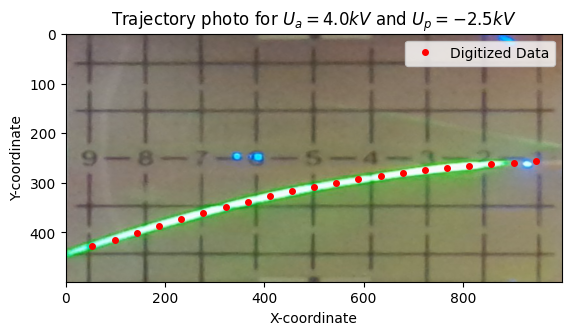

In [18]:
# URL of the image
image_url = 'https://github.com/tphlabs/data/blob/21c585f0f7bb13ff9063ba2728d934fd86560266/Lab2_EF/CollectData/083%20Ua%204.0%20Up%20-2.5%20I%200.000.png?raw=true'
data = '''
# x, y
	9.018	-1.856
	8.616	-1.71
	8.213	-1.566
	7.811	-1.425
	7.409	-1.289
	7.007	-1.158
	6.604	-1.034
	6.202	-0.917
	5.8	-0.806
	5.398	-0.701
	4.996	-0.606
	4.593	-0.52
	4.191	-0.444
	3.789	-0.376
	3.387	-0.315
	2.984	-0.261
	2.582	-0.214
	2.18	-0.171
	1.778	-0.132
	1.376	-0.096
	0.973	-0.063
'''
x, y = np.genfromtxt(data.splitlines(), skip_header=1, dtype=float).T

# Read the image from the URL
image = io.imread(image_url)

# Display the image
plt.imshow(image)

# scale to fit image
xright, xleft = 0.5, 9.5
ytop, ybottom = -2.6, 2.6
x_coord = 1000 - (xright - x) / (xright - xleft) * 1000
y_coord = (y - ybottom) / (ytop - ybottom)*500

# Plot the data over the image
plt.plot(x_coord, y_coord, 'ro', markersize=4, label='Digitized Data')

# Add labels and title
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title(r'Trajectory photo for $U_a=4.0 kV$ and $U_p=-2.5 kV$')
plt.legend()

# Show the plot
plt.show()


### Test data to be parabola

The trajectory $(x_i, y_i)$ is expected to be parabola $y = ax^2$. We assume the error in $x_i$ to be negligible and the error in $y_i$ to be $\sigma_y = 0.5mm$. Let's test our expectation with chi sqared statistics.

Reduced Chi-squared test statistic 0.56


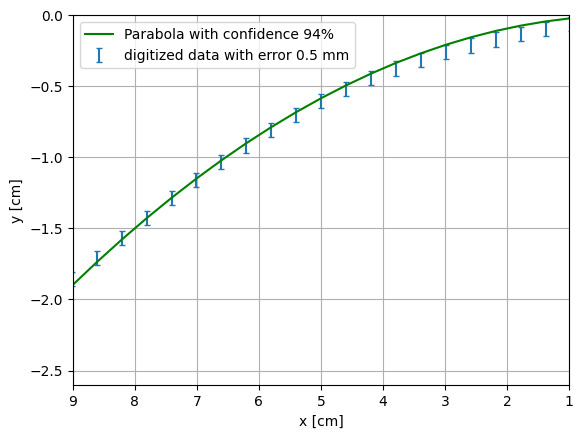

In [8]:
# measurements error estimated
sigma = 0.5e-1 # sigma_y error 0.5 mm

def parabola(x, a):
  return a*x**2

popt, _ = curve_fit(parabola, x, y)

y_expected = parabola(x, *popt)

chi2_observed = np.sum((y - y_expected)**2 / sigma**2)
DOF = x.size - 1 # degrees of freedom

# calculate Prob(ch2 > ch2_o)
p_value = chi2.sf(chi2_observed, DOF)

print(f'Reduced Chi-squared test statistic {chi2_observed/DOF:.2f}')
plt.errorbar(x, y, sigma, capsize=2, fmt='none', label=f'digitized data with error {sigma*10:.1f} mm')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.grid()
plt.plot(x, y_expected, color='green', label=f'Parabola with confidence {p_value*100:.0f}%')
plt.legend()
plt.ylim(-2.6, 0)
plt.xlim(9, 1)
plt.show()

Conclusion: given a measurement uncertainty of $\sigma_y = 0.5 \text{mm}$ we can conclude that the trajectory is likely to be a parabolic form $y=ax^2$.

### Play with accuarcy

What if we could measure the error five times more accurate?

Reduced Chi-squared test statistic 13.92


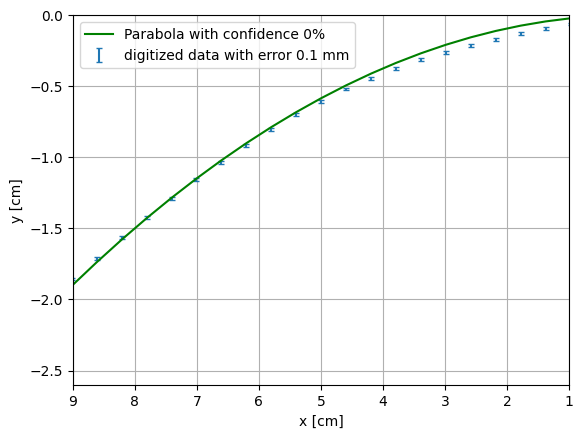

In [13]:
sigma = 0.1e-1 # sigma_y error 0.1 mm

chi2_observed = np.sum((y - y_expected)**2 / sigma**2)

# calculate Prob(ch2 > ch2_o)
p_value = chi2.sf(chi2_observed, DOF)

print(f'Reduced Chi-squared test statistic {chi2_observed/DOF:.2f}')
plt.errorbar(x, y, sigma, capsize=2, fmt='none', label=f'digitized data with error {sigma*10:.1f} mm')
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.grid()
plt.plot(x, y_expected, color='green', label=f'Parabola with confidence {p_value*100:.0f}%')
plt.legend()
plt.ylim(-2.6, 0)
plt.xlim(9, 1)
plt.show()

Conclusion: with a smaller uncertainty of $\sigma_y = 0.1 \text{mm}$ the reduced chi squared is too large, and we have to reject the hypothesis that the trajectory follows a parabolic form $y=ax^2$.